# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory. 
import os
#os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [2]:
# Install requirements
!pip install ipywidgets
!python -m pip install -r requirements.txt


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
training_data = torchvision.datasets.MNIST(root="data",train=True,download=True)

#Examine the data: shape, number of classes, number of datapoints
print("Training Data:",training_data,"\n")
print("Length:",len(training_data,),"\n")
print("Shape:",training_data.data.shape,"\n")
print("targets:",training_data.targets,"\n")
print("Classes:",training_data.classes,"\n")
print("IDX:",training_data.class_to_idx,"\n")



Training Data: Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train 

Length: 60000 

Shape: torch.Size([60000, 28, 28]) 

targets: tensor([5, 0, 4,  ..., 5, 6, 8]) 

Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'] 

IDX: {'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9} 



In [5]:
#Take a look at one picture
print("Picture info and length:\n")
print(training_data[0])
print(len(training_data[0]),"\n")

data, label = training_data[0]

print("data:",data)
print("label",label,type(label))

Picture info and length:

(<PIL.Image.Image image mode=L size=28x28 at 0x7FF2CD7C0670>, 5)
2 

data: <PIL.Image.Image image mode=L size=28x28 at 0x7FF2CD7C0670>
label 5 <class 'int'>


In [6]:
#find standard deviation and mean for normalization

transform = transforms.Compose([
    transforms.ToTensor()
])

t_image = transform(data)

mean = torch.mean(t_image, dim=(1, 2))
std = torch.std(t_image, dim=(1, 2))

print("Mean:", mean)
print("Standard Deviation:", std)

Mean: tensor([0.1377])
Standard Deviation: tensor([0.3125])


In [7]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.GaussianBlur(kernel_size=(11,11),sigma=(0.1,0.2)),
    transforms.Normalize((0.1377), (0.3125))])

# Create training set and define training dataloader
training_data = torchvision.datasets.MNIST(root="data",train=True,download=True,transform=transform)
training_loader = torch.utils.data.DataLoader(training_data,batch_size=16)

# Create test set and define test dataloader
test_data = torchvision.datasets.MNIST(root="data",train=False,download=True,transform=transform)
test_loader = torch.utils.data.DataLoader(training_data,batch_size=16)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I chose GaussianBlur to add some sort of effector to change the picture visualization but did not want to use something
that would alter the state of the image so that it would be confused with another number.  Normalizastion was used to 
make the pixel values between 0 and 1.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [8]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]

 
    fig = plt.figure()
    for i in range(5):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        print(int(labels[i].detach()))
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T, cmap='gray', interpolation='none')

        plt.show()


5


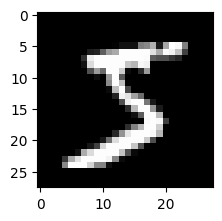

0


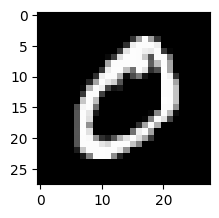

4


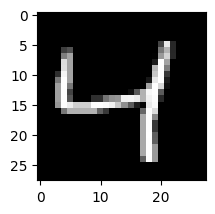

1


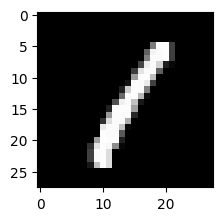

9


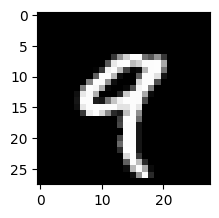

In [9]:
# Explore data
show5(training_loader)


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [10]:
#Create neural network class.  Initialization sets up the layers to go from 784 of the input layer
#to a 128 note hiddel layer to a 64 node hidden layer to a 10 node output layer...corresponding to each number.

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(28 * 28, 128)
        #self.fc2 = nn.Linear(512,128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.2)

#Function to add activation functions to each layers, 2 RELU then SOFTMAX for the output layer.
    def forward(self, x):
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        #x = self.dropout(x)
        #x = self.fc4(x)
        x = F.log_softmax(x,dim=1)
        return x


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [11]:
#initalize neural network
net = Net()
#net.to(device)

#ADAM optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Add Cross Entropy loss function
criterion = nn.CrossEntropyLoss()

net

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [12]:
epochs = 40
training_loss_history = list()


for epoch in range(epochs):
    net.train()
    train_loss = 0.0
 
    for i, data in enumerate(training_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)

        #compute loss using cross entropy
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f'Epoch {epoch +1} training loss: {train_loss/len(training_loader):.5f}')
    training_loss_history.append(train_loss/len(training_loader))
    

Epoch 1 training loss: 0.45365
Epoch 2 training loss: 0.18168
Epoch 3 training loss: 0.14916
Epoch 4 training loss: 0.13269
Epoch 5 training loss: 0.12380
Epoch 6 training loss: 0.11433
Epoch 7 training loss: 0.10922
Epoch 8 training loss: 0.10284
Epoch 9 training loss: 0.09840
Epoch 10 training loss: 0.09469
Epoch 11 training loss: 0.09105
Epoch 12 training loss: 0.09032
Epoch 13 training loss: 0.08808
Epoch 14 training loss: 0.08240
Epoch 15 training loss: 0.08374
Epoch 16 training loss: 0.07772
Epoch 17 training loss: 0.07884
Epoch 18 training loss: 0.07931
Epoch 19 training loss: 0.07987
Epoch 20 training loss: 0.07199
Epoch 21 training loss: 0.07398
Epoch 22 training loss: 0.07107
Epoch 23 training loss: 0.07149
Epoch 24 training loss: 0.07228
Epoch 25 training loss: 0.06963
Epoch 26 training loss: 0.06999
Epoch 27 training loss: 0.06456
Epoch 28 training loss: 0.06716
Epoch 29 training loss: 0.06702
Epoch 30 training loss: 0.06667
Epoch 31 training loss: 0.06547
Epoch 32 training

Plot the training loss (and validation loss/accuracy, if recorded).

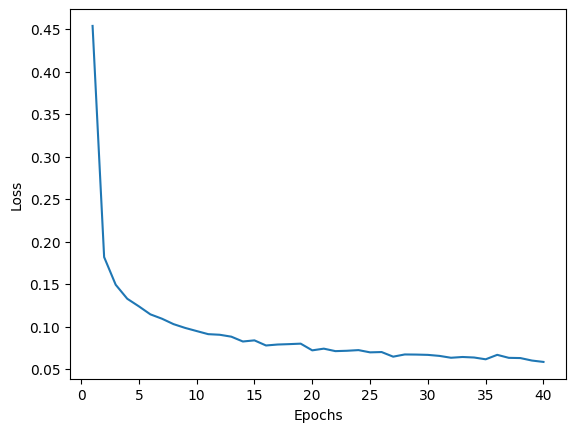

In [13]:
#Plot training loss
epochs = list(range(1,41))
fig =plt.figure()
plt.plot(epochs,training_loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
fig

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [14]:
num_correct = 0.0

for image, labels in test_loader:
    #Put model in eval mode
    net.eval()
    
    #Since this is a classification problems, model returns a 16x10 matrix.  16 is the batch size, 10 predictions each
    predictions = net(image)
    
    #Return the maximum value in each of the 16 rows which will be the highest classification
    _,predicted = torch.max(predictions,1)

    #compare the predicted value and the value from the original set of 16 images
    num_correct += (predicted == labels).sum()

accuracy = num_correct/(len(test_loader) * 16)
print(f'accuracy {accuracy:.5f}')                       

accuracy 0.99372


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

I did this iteratively while I was training the model.  I started out with stochastic gradient decent but shifted to ADAM.  I started with an accuracy of around 79%.  I added dropout layers and added softmax before the output layer.  I also experimented with different ADAM learning rate values.

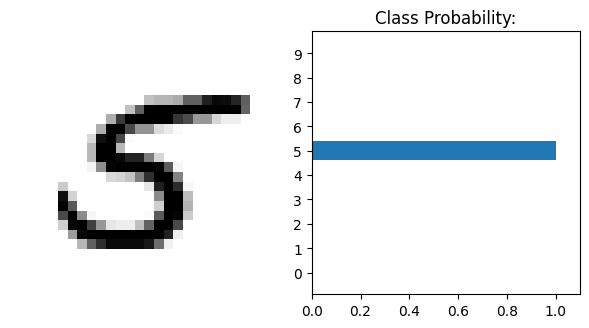

In [15]:
#Choose a random image and see how it predicts

random_number = random.randint(1, 10000)
image,label = test_data[random_number]

class_prediction = net(image)
_,prediction = torch.max(class_prediction,1) 

conv_class_prediction = torch.exp(class_prediction)

probabilities = conv_class_prediction[0].detach().numpy()

img = image.numpy().squeeze()

fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(img, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(10), probabilities)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability:')
ax2.set_xlim(0, 1.1)
plt.tight_layout()

fig



## Saving your model
Using `torch.save`, save your model for future loading.

In [19]:
#Save to default directory
torch.save(net.state_dict(),"digits_classifier.pth")